# **Convolutional Neural Network**
**Starting parameters**:

- Number of epochs: 100
- Learning rate: 0.0005
- Layers: [64, 32, 32]
- Dropout: 0.3


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Standard libraries
import numpy as np
import pandas as pd
import time
import os

# For preprocessing
import tensorflow as tf

# For modeling
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, roc_auc_score, f1_score
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import VGG16

# Operational
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import time
import random

In [3]:
pkl_path = '/content/drive/My Drive/Final-Year-Project/Dataset/Final-Version-of-Bird-Classification-Project/feature-extraction/Annotated/Regular/NotAveragePooled/split_features_3s_all_2D.pkl'

# Load the pickle file
with open(pkl_path, 'rb') as file:
    data = pickle.load(file)
del file

In [19]:
path = '/content/drive/My Drive/Final-Year-Project/Final-Version-of-Bird-Classification-Project/Final-Version-of-Bird-Classification-Project/a. Imbalanced-Data/3. Training/Figures/CNN/'

In [5]:
train_data = data['train'].copy()
val_data = data['val'].copy()
del data

train_labels = train_data['label'].copy()
temp = train_data.copy()
del temp['label']
tr_features = temp

val_labels = val_data['label'].copy()
temp = val_data.copy()
del temp['label']
v_features = temp

## **Shuffling Data**

In [6]:
def shuffle_data(input_label, input_features):
  input_len = len(input_label)
  np.random.seed(1826)
  input_indices = np.random.permutation(input_len)
  input_features = {key: np.array([input_features[key][i] for i in input_indices]) for key in input_features} # dictionary comprehension
  input_label = np.array([input_label[i] for i in input_indices])

  return input_label, input_features

In [7]:
train_y, train_features = shuffle_data(train_labels, tr_features)

In [8]:
val_y, val_features = shuffle_data(val_labels, v_features)

## **CNN Model**

In [32]:
from tensorflow.keras.applications import EfficientNetB4

def build_efficientnet_model(audio_features, learning_rate=0.00005, num_classes=20):
    tf.keras.backend.clear_session()

    # Load EfficientNetB0 with ImageNet weights, excluding the top layer
    base_model = EfficientNetB4(weights='imagenet', include_top=False, input_shape=(audio_features.shape[1], audio_features.shape[2], audio_features.shape[3]))

    # Unfreeze last few layers for fine-tuning
    for layer in base_model.layers[-10:]:
        layer.trainable = True

    # Input layer for the audio features
    inputs = tf.keras.layers.Input(shape=(audio_features.shape[1], audio_features.shape[2], audio_features.shape[3]), name='Audio_Features')

    # Extract features using the base model
    features = base_model(inputs)

    # Add a global average pooling layer
    features = tf.keras.layers.GlobalAveragePooling2D()(features)

    # Add Batch Normalization
    features = tf.keras.layers.BatchNormalization()(features)

    # Add a custom fully connected (dense) layer
    features = tf.keras.layers.Dense(
        units=128,
        activation='relu',
        kernel_regularizer=tf.keras.regularizers.l2(0.00015),
        name='fc_1')(features)

    # Add dropout layer for regularization
    features = tf.keras.layers.Dropout(rate=0.4)(features)

    features = tf.keras.layers.Dense(
        units=64,
        activation='relu',
        kernel_regularizer=tf.keras.regularizers.l2(0.00015),
        name='fc_2')(features)

    # Add Batch Normalization
    features = tf.keras.layers.BatchNormalization()(features)

    features = tf.keras.layers.Dropout(rate=0.4)(features)

    # Output layer with softmax activation
    outputs = tf.keras.layers.Dense(
        units=num_classes,
        activation='softmax',
        name='fc_output')(features)

    # Build the model
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name='EfficientNetB0_Audio_Classification')

    print(model.summary())

    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])

    return model

In [33]:
def visualize(model_history, name):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    # Visualize the loss
    axes[0].plot(model_history.history['loss'], color='red', label='Training Loss')
    axes[0].plot(model_history.history['val_loss'], color='blue', label='Validation Loss')
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Loss', fontsize=12)
    axes[0].set_title('Loss Progression', fontsize=14)
    axes[0].grid(True)
    axes[0].legend()

    # Visualize the accuracy
    axes[1].plot(model_history.history['accuracy'], color='green', label='Training Accuracy')
    axes[1].plot(model_history.history['val_accuracy'], color='orange', label='Validation Accuracy')
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Accuracy', fontsize=12)
    axes[1].set_title('Accuracy Progression', fontsize=14)
    axes[1].grid(True)
    axes[1].legend()

    plt.savefig(f'{path+name}_3s_model_training_history_2D_annotated_EfficientNetB4.pdf')

    # Fine-tune layout and display the plots
    plt.tight_layout()
    plt.show()

In [34]:
def evaluate_model(val_y, val_yhat, val_yhat_result, num_classes=20):

    print('Validation classification Report \n')
    print(classification_report(val_y, val_yhat_result))

    # Calculate AUC for multiclass classification using 'ovr' and 'weighted' average
    auc_score = roc_auc_score(val_y, val_yhat, multi_class='ovr', average='weighted')
    print(f'AUC Score: {auc_score}')

    # Calculate F1-score with 'weighted' average for imbalanced dataset
    f1 = f1_score(val_y, val_yhat_result, average='weighted')
    print(f'F1 Score (Weighted): {f1}')

    val_score = {'f1': f1, 'auc': auc_score}

    return val_score

In [35]:
def tile_and_crop(feature, target_size):
    tiled = np.tile(feature, (1, target_size // feature.shape[1] + 1, 1))
    return tiled[:, :target_size, :]

In [36]:
train_results = {}
val_results = {}

val_scores = {}

### With Mel Spectrogram, MFCCs and Chroma

In [37]:
# Validation Features
target_size = 128
mfcc_tiled = tile_and_crop(val_features['mfcc'], target_size)
chroma_tiled = tile_and_crop(val_features['chroma'], target_size)

validation_features = np.stack((val_features['melspectrogram'], mfcc_tiled, chroma_tiled), axis=-1)
print(validation_features.shape)

(1350, 128, 259, 3)


In [38]:
# Train features
target_size = 128
mfcc_tiled = tile_and_crop(train_features['mfcc'], target_size)
chroma_tiled = tile_and_crop(train_features['chroma'], target_size)

training_features = np.stack((train_features['melspectrogram'], mfcc_tiled, chroma_tiled), axis=-1)
print(training_features.shape)

(5278, 128, 259, 3)


In [39]:
model = build_efficientnet_model(training_features)

history = model.fit(
    x=training_features,
    y=train_y,
    epochs=60,
    validation_data=(
        validation_features,
        val_y,
    ),
    batch_size=32,
    verbose=1
)

71686520/71686520 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "EfficientNetB0_Audio_Classification"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Audio_Features (InputLayer)          │ (None, 128, 259, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb4 (Functional)          │ (None, 4, 9, 1792)          │      17,673,823 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1792)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1792)                │           7,168 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc_1 (Dense)                         │ (None, 128)                 │         229,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc_2 (Dense)                         │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc_output (Dense)                    │ (None, 20)                  │           1,300 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,920,307 (68.36 MB)

 Trainable params: 17,791,388 (67.87 MB)

 Non-trainable params: 128,919 (503.59 KB)

None
Epoch 1/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 295s 902ms/step - accuracy: 0.1053 - loss: 3.5778 - val_accuracy: 0.0133 - val_loss: 3.1703
Epoch 2/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 41s 248ms/step - accuracy: 0.3020 - loss: 2.4079 - val_accuracy: 0.0363 - val_loss: 3.3790
Epoch 3/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 42s 251ms/step - accuracy: 0.5022 - loss: 1.7366 - val_accuracy: 0.0578 - val_loss: 3.2514
Epoch 4/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 42s 254ms/step - accuracy: 0.6047 - loss: 1.4296 - val_accuracy: 0.1770 - val_loss: 2.8894
Epoch 5/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 42s 253ms/step - accuracy: 0.6927 - loss: 1.1574 - val_accuracy: 0.4511 - val_loss: 1.9927
Epoch 6/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 42s 254ms/step - accuracy: 0.7464 - loss: 1.0002 - val_accuracy: 0.6785 - val_loss: 1.1508
Epoch 7/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 42s 254ms/step - accuracy: 0.7949 - loss: 0.8459 - val_accuracy: 0.7489 - val_loss: 0.9685
Epoch 8/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 42s 254ms/step - accuracy: 0.8158 - l

In [40]:
model.save('/content/drive/My Drive/Final-Year-Project/Dataset/Final-Version-of-Bird-Classification-Project/ML Models/Transfer Learning/EfficientB4_melspectrogram_chroma_mfcc.keras')

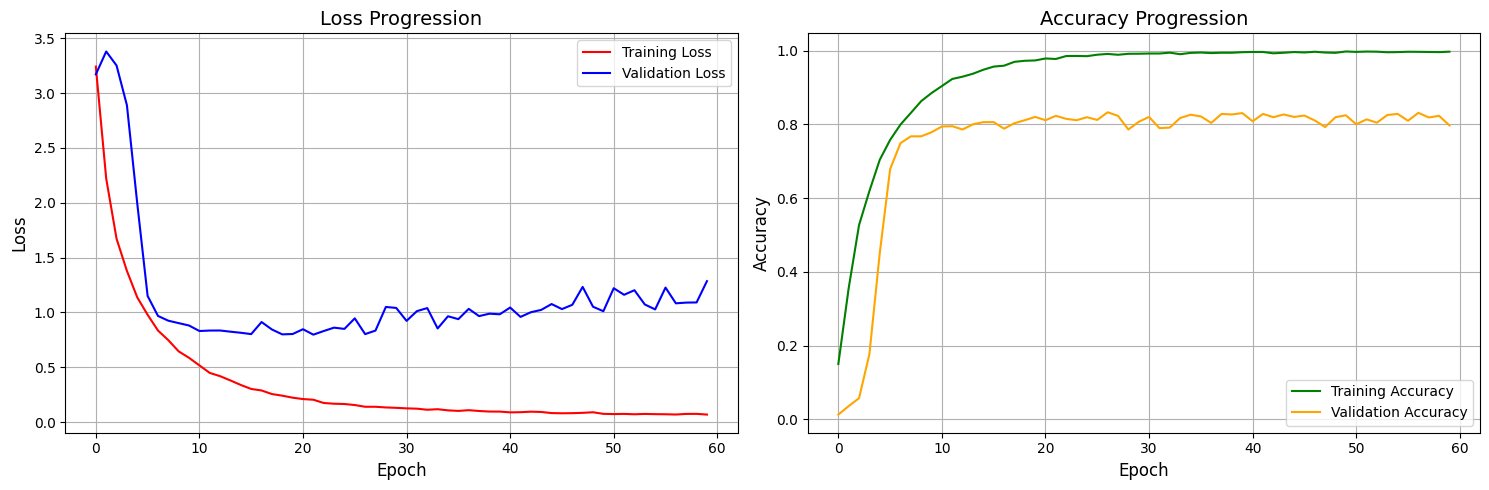

In [41]:
visualize(history, 'melspectrogram_chroma_mfcc')

In [42]:
train_yhat = model.predict(training_features)
train_yhat_result = np.argmax(train_yhat, axis=-1)
train_results['melspectrogram_chroma_mfcc'] = model.evaluate(training_features, train_y)[-1]

val_yhat = model.predict(validation_features)
val_yhat_result = np.argmax(val_yhat, axis=-1)
val_results['melspectrogram_chroma_mfcc'] = model.evaluate(validation_features, val_y)[-1]

165/165 ━━━━━━━━━━━━━━━━━━━━ 30s 119ms/step
165/165 ━━━━━━━━━━━━━━━━━━━━ 17s 101ms/step - accuracy: 0.9993 - loss: 0.0497
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 190ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - accuracy: 0.8032 - loss: 1.2828


In [43]:
val_scores['melspectrogram_chroma_mfcc'] = evaluate_model(val_y=val_y, val_yhat=val_yhat, val_yhat_result=val_yhat_result)

Validation classification Report 

              precision    recall  f1-score   support

           0       0.92      0.96      0.94       114
           1       0.54      0.82      0.65       141
           2       0.90      0.64      0.75       271
           3       0.95      1.00      0.97        90
           4       0.71      0.56      0.62        18
           5       0.67      0.67      0.67        15
           6       0.36      0.87      0.51        23
           7       0.98      1.00      0.99        44
           8       0.80      0.80      0.80        50
           9       0.98      0.98      0.98        49
          10       0.81      0.90      0.85        48
          11       0.85      0.61      0.71        46
          12       0.98      1.00      0.99        54
          13       0.77      0.35      0.49        48
          14       0.40      0.87      0.55        38
          15       0.97      0.57      0.72       117
          16       0.98      1.00      0.99   

### With Mel Spectrogram and MFCCs and CQT

In [44]:
# Train features
target_size = 128
mfcc_tiled = tile_and_crop(train_features['mfcc'], target_size)
cqt_tiled = tile_and_crop(train_features['cqt'], target_size)

training_features = np.stack((train_features['melspectrogram'], mfcc_tiled, cqt_tiled), axis=-1)
print(training_features.shape)

(5278, 128, 259, 3)


In [45]:
# Validation Features
target_size = 128
mfcc_tiled = tile_and_crop(val_features['mfcc'], target_size)
cqt_tiled = tile_and_crop(val_features['cqt'], target_size)

validation_features = np.stack((val_features['melspectrogram'], mfcc_tiled, cqt_tiled), axis=-1)
print(validation_features.shape)

(1350, 128, 259, 3)


In [46]:
model = build_efficientnet_model(training_features)

history = model.fit(
    x=training_features,
    y=train_y,
    epochs=60,
    validation_data=(
        validation_features,
        val_y,
    ),
    batch_size=32,
    verbose=1
)

Model: "EfficientNetB0_Audio_Classification"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Audio_Features (InputLayer)          │ (None, 128, 259, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb4 (Functional)          │ (None, 4, 9, 1792)          │      17,673,823 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1792)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1792)                │           7,168 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc_1 (Dense)                         │ (None, 128)                 │         229,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc_2 (Dense)                         │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc_output (Dense)                    │ (None, 20)                  │           1,300 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,920,307 (68.36 MB)

 Trainable params: 17,791,388 (67.87 MB)

 Non-trainable params: 128,919 (503.59 KB)

None
Epoch 1/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 257s 788ms/step - accuracy: 0.0989 - loss: 3.6691 - val_accuracy: 0.0452 - val_loss: 3.2463
Epoch 2/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 41s 249ms/step - accuracy: 0.3203 - loss: 2.4205 - val_accuracy: 0.0193 - val_loss: 3.4649
Epoch 3/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 42s 254ms/step - accuracy: 0.4443 - loss: 1.9042 - val_accuracy: 0.0711 - val_loss: 3.3327
Epoch 4/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 42s 254ms/step - accuracy: 0.5506 - loss: 1.5837 - val_accuracy: 0.4230 - val_loss: 2.1778
Epoch 5/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 42s 254ms/step - accuracy: 0.6307 - loss: 1.3475 - val_accuracy: 0.6081 - val_loss: 1.4549
Epoch 6/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 42s 253ms/step - accuracy: 0.6928 - loss: 1.1623 - val_accuracy: 0.6474 - val_loss: 1.3557
Epoch 7/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 42s 253ms/step - accuracy: 0.7506 - loss: 0.9933 - val_accuracy: 0.6630 - val_loss: 1.3233
Epoch 8/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 42s 252ms/step - accuracy: 0.7924 - l

In [47]:
model.save('/content/drive/My Drive/Final-Year-Project/Dataset/Final-Version-of-Bird-Classification-Project/ML Models/Transfer Learning/EfficientB4_melspectrogram_cqt_mfcc.keras')

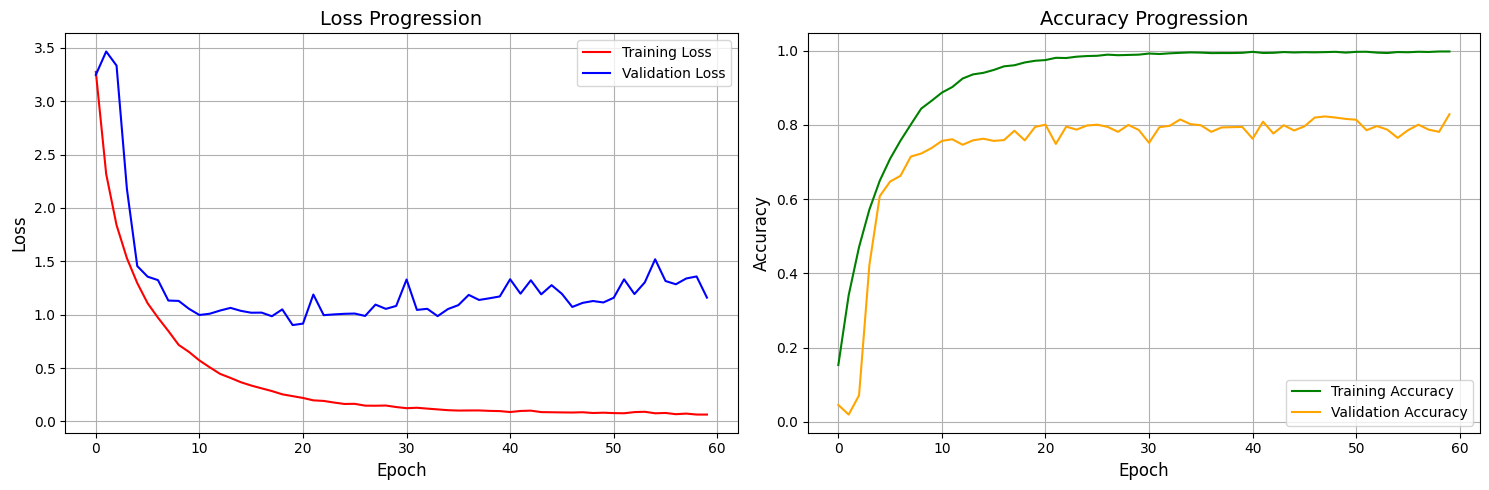

In [48]:
visualize(history, 'mfcc_melspectrogram_cqt')

In [49]:
train_yhat = model.predict(training_features)
train_yhat_result = np.argmax(train_yhat, axis=-1)
train_results['mfcc_melspectrogram_cqt'] = model.evaluate(training_features, train_y)[-1]

val_yhat = model.predict(validation_features)
val_yhat_result = np.argmax(val_yhat, axis=-1)
val_results['mfcc_melspectrogram_cqt'] = model.evaluate(validation_features, val_y)[-1]

165/165 ━━━━━━━━━━━━━━━━━━━━ 29s 115ms/step
165/165 ━━━━━━━━━━━━━━━━━━━━ 16s 99ms/step - accuracy: 0.9997 - loss: 0.0450
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 179ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - accuracy: 0.8228 - loss: 1.1885


In [50]:
val_scores['mfcc_melspectrogram_cqt'] = evaluate_model(val_y=val_y, val_yhat=val_yhat, val_yhat_result=val_yhat_result)

Validation classification Report 

              precision    recall  f1-score   support

           0       0.90      0.93      0.91       114
           1       0.74      0.76      0.75       141
           2       0.88      0.86      0.87       271
           3       0.76      0.87      0.81        90
           4       0.00      0.00      0.00        18
           5       0.62      0.67      0.65        15
           6       0.76      0.70      0.73        23
           7       0.98      1.00      0.99        44
           8       0.81      0.96      0.88        50
           9       0.89      1.00      0.94        49
          10       0.64      0.81      0.72        48
          11       0.87      0.74      0.80        46
          12       1.00      0.98      0.99        54
          13       0.55      0.83      0.66        48
          14       0.74      0.82      0.78        38
          15       0.80      0.60      0.69       117
          16       1.00      0.98      0.99   

## Review all the results

In [51]:
train_results_df = pd.DataFrame(list(train_results.items()), columns=['Features', 'Train_Accuracy']).round(3)
val_results_df = pd.DataFrame(list(val_results.items()), columns=['Features', 'Val_Accuracy']).round(3)

result_df = train_results_df.merge(val_results_df, on='Features')
result_df = result_df.sort_values('Features')
result_df

,Features,Train_Accuracy,Val_Accuracy
0,melspectrogram_chroma_mfcc,1.0,0.797
1,mfcc_melspectrogram_cqt,1.0,0.829


In [52]:
val_scores_df = pd.DataFrame([(key, value['f1'], value['auc']) for key, value in val_scores.items()],
                             columns=['Features', 'F1_Score', 'AUC_Score']).round(3)

val_scores_df = val_scores_df.sort_values('Features')
print(val_scores_df)

                     Features  F1_Score  AUC_Score
0  melspectrogram_chroma_mfcc     0.801      0.969
1     mfcc_melspectrogram_cqt     0.824      0.970
